<a href="https://colab.research.google.com/github/nfarkas7/TMU-final-project-codes/blob/main/TMU_final_project_draft_code_feature_engineering_and_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FEATURE ENGINEERING - creating dummy variables

In [1]:
# LIBRARIES
import urllib
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os


#import data

from google.colab import files
uploaded = files.upload()


no_outliers_df = pd.read_csv('no_outliers_df.csv')

# Display the first few rows of the DataFrame
no_outliers_df.head()

Saving no_outliers_df.csv to no_outliers_df (3).csv


<ipython-input-1-db4778af49a4>:19: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  no_outliers_df = pd.read_csv('no_outliers_df.csv')


,Time,Day,Location,Incident,Vehicle,delay_combined,bound_or_direction,route_or_line,date_consolidated,delay_group
0,00:23:00,Wednesday,York Mills station,Mechanical,1734.0,10.0,E,95,2014-01-01,medium
1,00:55:00,Wednesday,Entire run for route,General Delay,8110.0,33.0,B/W,102,2014-01-01,very high
2,01:28:00,Wednesday,lawrence and Warden,Mechanical,7478.0,10.0,WB,54,2014-01-01,medium
3,01:30:00,Wednesday,Kipling Station,Emergency Services,8084.0,18.0,N,112,2014-01-01,very high
4,01:37:00,Wednesday,VP and Ellesmere,Investigation,7843.0,10.0,N,24,2014-01-01,medium


#CREATING DUMMY VARIABLES

In [2]:
#import warnings

# Ignore only UserWarning
#warnings.filterwarnings('ignore', category=UserWarning)

# Define the chunk size based on your available memory (10,000 rows is a conservative start)
chunk_size = 10000
chunks = []

# Process the data in chunks
for start in range(0, no_outliers_df.shape[0], chunk_size):
    end = start + chunk_size
    chunk = no_outliers_df.iloc[start:end]
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
combined_df = pd.concat(chunks, axis=0)

# Convert necessary columns to strings to avoid mixed type issues
for col in ['Day', 'Incident']:
    combined_df[col] = combined_df[col].astype(str)

# Create dummy variables for the entire concatenated DataFrame
day_dummies = pd.get_dummies(combined_df['Day'], prefix='day')
#location_dummies = pd.get_dummies(combined_df['Location'], prefix='location')
incident_dummies = pd.get_dummies(combined_df['Incident'], prefix='incident')
bound_direction_dummies = pd.get_dummies(combined_df['bound_or_direction'], prefix='direction')
#route_line_dummies = pd.get_dummies(combined_df['route_or_line'], prefix='route')
delay_group_dummies = pd.get_dummies(combined_df['delay_group'], prefix='delaygrp')

# Combine the original DataFrame with the dummy variables
combined_df = combined_df.drop(columns=['Day', 'Incident', 'bound_or_direction', 'route_or_line', 'delay_group']) #'Location'
combined_df = combined_df.join([day_dummies,  incident_dummies, bound_direction_dummies, delay_group_dummies]) #location_dummies, route_line_dummies,

# Drop the target variable column if necessary
model_df = combined_df.drop(columns= ['y', 'Time', 'Location', 'date_consolidated', 'delay_combined'], errors='ignore')



# Display the resulting DataFrame
display(model_df)


,Vehicle,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,incident_Cleaning,incident_Cleaning - Disinfection,...,direction_`S,direction_`S/B,direction_`SB,direction_`W,direction_`W/B,direction_`WB,delaygrp_high,delaygrp_low,delaygrp_medium,delaygrp_very high
0,1734.0,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
1,8110.0,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
2,7478.0,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
3,8084.0,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
4,7843.0,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653088,4504.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
653089,4579.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
653090,4459.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
653091,4589.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


#ALGORITHM 1 - Decision Tree

In [3]:

#from sklearn.ensemble import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

In [4]:
#preparing the data - predicting "very high delays"

# Define feature matrix X and target vector y
X = model_df.iloc[:, :-4]
#y = model_df.iloc[:,-4:]
y= model_df['delaygrp_very high']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Initialize and train the decision tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = decision_tree.predict(X_test)

# Evaluate the model
print("Decision Tree Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))


Decision Tree Classifier
Accuracy: 0.7215642440992505
Confusion Matrix:
 [[83718 15991]
 [20378 10532]]
Classification Report:
               precision    recall  f1-score   support

       False       0.80      0.84      0.82     99709
        True       0.40      0.34      0.37     30910

    accuracy                           0.72    130619
   macro avg       0.60      0.59      0.59    130619
weighted avg       0.71      0.72      0.71    130619



In [7]:
# Initialize and train the random forest classifier
random_forest = RandomForestClassifier(random_state=42, n_estimators=10)
random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = random_forest.predict(X_test)

# Evaluate the model
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Classifier
Accuracy: 0.7242514488703787
Confusion Matrix:
 [[83997 15712]
 [20306 10604]]
Classification Report:
               precision    recall  f1-score   support

       False       0.81      0.84      0.82     99709
        True       0.40      0.34      0.37     30910

    accuracy                           0.72    130619
   macro avg       0.60      0.59      0.60    130619
weighted avg       0.71      0.72      0.72    130619



#RELATIVE FEATURE IMPORTANCE

<ipython-input-11-dbddaec76d4f>:5: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Ensures the labels fit within the figure


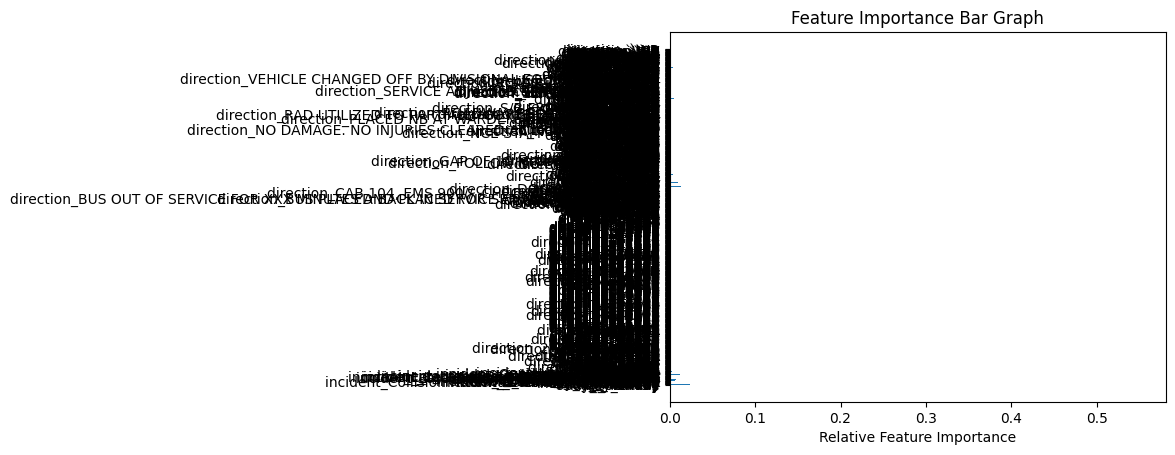

In [11]:
#relative feature importance (of all the variables)**
plt.barh(X.columns, decision_tree.feature_importances_)
plt.xlabel('Relative Feature Importance')
plt.title('Feature Importance Bar Graph')
plt.tight_layout()  # Ensures the labels fit within the figure

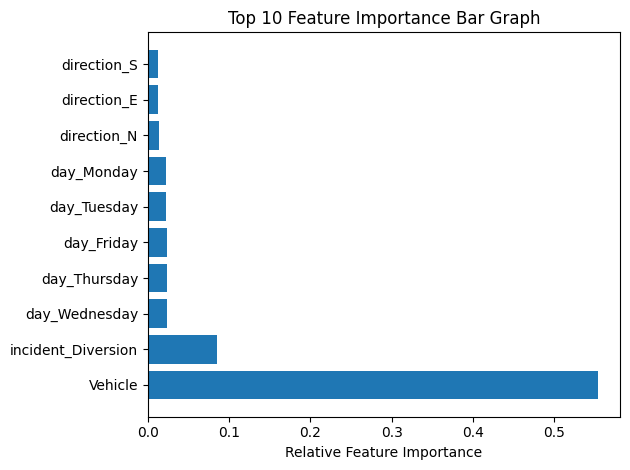

In [12]:

# what about the top 10 attributes with the highest importance?
feature_names = X.columns
feature_importance = decision_tree.feature_importances_

# Sort features based on the absolute values of coefficients
sorted_indices = sorted(range(len(feature_importance)), key=lambda k: abs(feature_importance[k]), reverse=True)
top_features = [feature_names[i] for i in sorted_indices[:10]]
top_importance = [feature_importance[i] for i in sorted_indices[:10]]

# Increase the space between the y-axis ticks
plt.barh(range(len(top_features)), top_importance)
plt.yticks(range(len(top_features)), top_features, ha='right')  # 'ha' stands for horizontal alignment
plt.xlabel('Relative Feature Importance')
plt.title('Top 10 Feature Importance Bar Graph')
plt.tight_layout()  # Ensures the labels fit within the figure
plt.show()

In [ ]:
#try breaking it up - weekend or weekday?
#vehicle - certain physical vehicles are delaying more than others - looking at vehicle numbers might give clues (to enhance model)

#ALGORITHM 2 - KNN

In [ ]:
# K-Nearest Neighbors Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np


knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("K-Nearest Neighbors Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

#note- it crashes from using too much RAM

#COMPARING THE RESULTS

In [ ]:

# Comparing results
results = {
    'Model': ['Decision Tree', 'Random Forest', 'K-Nearest Neighbors'],
    'Accuracy': [accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_knn)]
}

results_df = pd.DataFrame(results)

#ALGORITHM 3 - Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import numpy as np

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import numpy as np


# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC Score: {roc_auc:.2f}')

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)


#NOTE - you need to clean location and direction more to increase the predictability of the model - right now you just commented it out when you created the dummy variables so SOMETHING would work